In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transactions-fraud-datasets/mcc_codes.json
/kaggle/input/transactions-fraud-datasets/users_data.csv
/kaggle/input/transactions-fraud-datasets/transactions_data.csv
/kaggle/input/transactions-fraud-datasets/cards_data.csv
/kaggle/input/transactions-fraud-datasets/train_fraud_labels.json


In [2]:
import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots                                                         
import plotly.io as pio
pio.renderers.default="iframe_connected"
from itertools import islice
import warnings
warnings.filterwarnings("ignore")

#  Transaction Data

In [3]:
txn_df = pd.read_csv('/kaggle/input/transactions-fraud-datasets/transactions_data.csv')
txn_df

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,$1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,$12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,$40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,$4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN


In [4]:
txn_df.describe()

,id,client_id,card_id,merchant_id,zip,mcc
count,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.165321e+07,1.330592e+07
mean,1.558402e+07,1.026812e+03,3.475268e+03,4.772376e+04,5.132782e+04,5.565440e+03
std,4.704499e+06,5.816386e+02,1.674356e+03,2.581534e+04,2.940423e+04,8.757002e+02
min,7.475327e+06,0.000000e+00,0.000000e+00,1.000000e+00,1.001000e+03,1.711000e+03
25%,1.150604e+07,5.190000e+02,2.413000e+03,2.588700e+04,2.860200e+04,5.300000e+03
50%,1.557087e+07,1.070000e+03,3.584000e+03,4.592600e+04,4.767000e+04,5.499000e+03
75%,1.965361e+07,1.531000e+03,4.901000e+03,6.757000e+04,7.790100e+04,5.812000e+03
max,2.376187e+07,1.998000e+03,6.144000e+03,1.003420e+05,9.992800e+04,9.402000e+03


In [5]:
txn_df.dtypes

id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

In [6]:
txn_df.date = pd.to_datetime(txn_df.date) # convert date to datetime
txn_df.amount = txn_df.amount.str.replace('$', '').astype(float)
txn_df.dtypes

id                         int64
date              datetime64[ns]
client_id                  int64
card_id                    int64
amount                   float64
use_chip                  object
merchant_id                int64
merchant_city             object
merchant_state            object
zip                      float64
mcc                        int64
errors                    object
dtype: object

## Check NULLs

In [7]:
txn_df.isna().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

###   1. Handle NULL `merchant_state`

In [8]:
nan_state = txn_df[txn_df.merchant_state.isna()]

In [9]:
print(nan_state.shape)
nan_state.head()

(1563700, 12)


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
7,7475335,2010-01-01 00:14:00,1684,2140,26.46,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
8,7475336,2010-01-01 00:21:00,335,5131,261.58,Online Transaction,50292,ONLINE,NaN,NaN,7801,NaN
18,7475346,2010-01-01 00:34:00,394,4717,26.04,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
24,7475353,2010-01-01 00:43:00,301,3742,10.17,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
26,7475356,2010-01-01 00:45:00,566,3439,16.86,Online Transaction,16798,ONLINE,NaN,NaN,4121,NaN


In [10]:
nan_state.merchant_city.unique()

array(['ONLINE'], dtype=object)

In [11]:
txn_df.merchant_state.fillna('ONLINE', inplace = True)
txn_df.isna().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                1652706
mcc                      0
errors            13094522
dtype: int64

###   2. Handle NULL `zip`

In [12]:
nan_zip = txn_df[txn_df.zip.isna()]
nan_zip.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
7,7475335,2010-01-01 00:14:00,1684,2140,26.46,Online Transaction,39021,ONLINE,ONLINE,NaN,4784,NaN
8,7475336,2010-01-01 00:21:00,335,5131,261.58,Online Transaction,50292,ONLINE,ONLINE,NaN,7801,NaN
18,7475346,2010-01-01 00:34:00,394,4717,26.04,Online Transaction,39021,ONLINE,ONLINE,NaN,4784,NaN
24,7475353,2010-01-01 00:43:00,301,3742,10.17,Online Transaction,39021,ONLINE,ONLINE,NaN,4784,NaN
26,7475356,2010-01-01 00:45:00,566,3439,16.86,Online Transaction,16798,ONLINE,ONLINE,NaN,4121,NaN


In [13]:
txn_df.loc[txn_df["merchant_city"] == "ONLINE", 'zip'] = 0 
txn_df.isna().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                  89006
mcc                      0
errors            13094522
dtype: int64

In [14]:
# Lookup I got, just to fill in values. Can skip if you want
missing_zip = {
  "Puerto Vallarta": "48300","Vatican City": "00120","Guadalajara": "44100","Santo Domingo": "10101","Montreal": "H3A","Toronto": "M5H","San Jose": "10101","Berlin": "10115","Mexico City": "01000","Shanghai": "200000","Cancun": "77500","Edinburgh": "EH1","Tallinn": "10111","Funafuti": "","Tapei": "100","Abu Dhabi": "00000","Beijing": "100000","Vilnius": "01100","Amsterdam": "1011","Tokyo": "100-0001","Athens": "10552","Ho Chi Minh City": "700000","Port au Prince": "6110","Dublin": "D01","Singapore": "018989","Paris": "75001","Johannesberg": "","Cabo San Lucas": "23450","Bangkok": "10200","Rome": "00184","Copenhagen": "1050","Kingston": "","Porto-Novo": "","London": "SW1A 1AA","Edmonton": "T5J","Calgary": "T2P","Brussels": "1000","Freetown": "","Jakarta": "10110","Bogota": "110111","Geneva": "1201","Vancouver": "V5K","Lisbon": "1100-148",
  "Wellington": "6011","Amman": "11118","Guatamala City": "01001","Hong Kong": "999077","Helsinki": "00100","Ulan Bator": "15160","Riyadh": "12611","Manila": "1000","Oslo": "0150","Budapest": "1051","Seoul": "04524","Jerusalem": "91000","Mumbai": "400001","Sydney": "2000","Monaco": "98000","Bucharest": "010011","Saint Petersburg": "190000","Vienna": "1010","Majuro": "96960","Delhi": "110001","Barcelona": "08001","Zurich": "8001","Oranjestad": "","Lima": "15001","Chisinau": "MD-2001","Acapulco": "39300","Dhaka": "1000","Madrid": "28001","Sao Paulo": "01000-000","Palikir": "96941","Tashkent": "100000","Santiago": "8320000",
  "Zagreb": "10000","Kolkata": "700001","Bangalore": "560001","Rio de Janeiro": "20000-000","Stockholm": "11120","Bandar Seri Begawan": "BA1111","Saint John's": "","Andorra La Vella": "AD500","Nairobi": "00100","Prague": "110 00","Nuku Alofa": "","Asmara": "","Honiara": "","Islamabad": "44000","Nassau": "","Rabat": "10000","Suva": "","Muscat": "113","Yaounde": "","Skopje": "1000","Tegucigalpa": "11101","Abuja": "900001","Belmopan": "","Montevideo": "11000","Istanbul": "34000","Manama": "","Moscow": "101000","Kuala Lumpur": "50000","Luxembourg": "L-1111","Algiers": "16000","Bridgetown": "BB11114",
  "Niamey": "","Cairo": "11511","Hanoi": "100000","Accra": "00233","Bratislava": "811 01","Kiev": "01001","Yaren District": "","Buenos Aires": "C1000","Juba": "","Podgorica": "81000","Colombo": "00100","Lahore": "54000","Reykjavik": "101","Ljubljana": "1000","Sanaa": "","Riga": "LV-1050","Doha": "00000","Karachi": "74000","Male": "20026","Ouagadougou": "","Harare": "","Praia": "","Malabo": "","Port Vila": "","Addis Ababa": "1000","Mbabane": "","Maputo": "1100","Warsaw": "00-001","Lusaka": "10101","Kingstown": "",
  "Tblisi": "0105","Baghdad": "10001","Apia": "","Monrovia": "1000","Bamako": "","Nicosia": "1010","Quito": "170101","Dakar": "","Libreville": "","Belgrade": "11000","Tunis": "1000","Pristina": "10000","Bishek": "720001","Victoria": "","Sarajevo": "71000","Panama City": "0819","Paramaribo": "","Yamoussoukro": "","Yangon": "11181","Tehran": "11369","Beirut": "1107","Valletta": "VLT 1117","Tirana": "1001","Conakry": "","Port Moresby": "111","Dili": "","Caracas": "1010","Khartoum": "11111","Port of Spain": "","Brazzaville": "","Baku": "AZ1000","Georgetown": "","Sao Paolo": "01000-000"
}


In [15]:
txn_df["zip"] = txn_df["zip"].fillna(txn_df["merchant_city"].map(missing_zip))
txn_df.isna().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                      0
mcc                      0
errors            13094522
dtype: int64

###   3. Handle NULL `error`

In [16]:
txn_df[txn_df.errors.isna()].fillna('No Errors', inplace = True)
txn_df.isna().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                      0
mcc                      0
errors            13094522
dtype: int64

The above didn't work because of `chained indexing.`

Pandas does not guarantee whether: `df[condition]` returns a view or a copy — so inplace=True becomes unreliable.

In [17]:
txn_df['errors'].fillna('No Errors', inplace = True)
txn_df.isna().sum()

id                0
date              0
client_id         0
card_id           0
amount            0
use_chip          0
merchant_id       0
merchant_city     0
merchant_state    0
zip               0
mcc               0
errors            0
dtype: int64

In [18]:
txn_df.describe()

,id,date,client_id,card_id,amount,merchant_id,mcc
count,1.330592e+07,13305915,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07
mean,1.558402e+07,2015-01-06 06:50:27.604354816,1.026812e+03,3.475268e+03,4.297604e+01,4.772376e+04,5.565440e+03
min,7.475327e+06,2010-01-01 00:01:00,0.000000e+00,0.000000e+00,-5.000000e+02,1.000000e+00,1.711000e+03
25%,1.150604e+07,2012-08-08 21:43:00,5.190000e+02,2.413000e+03,8.930000e+00,2.588700e+04,5.300000e+03
50%,1.557087e+07,2015-01-22 12:17:00,1.070000e+03,3.584000e+03,2.899000e+01,4.592600e+04,5.499000e+03
75%,1.965361e+07,2017-06-13 17:45:00,1.531000e+03,4.901000e+03,6.371000e+01,6.757000e+04,5.812000e+03
max,2.376187e+07,2019-10-31 23:59:00,1.998000e+03,6.144000e+03,6.820200e+03,1.003420e+05,9.402000e+03
std,4.704499e+06,NaN,5.816386e+02,1.674356e+03,8.165575e+01,2.581534e+04,8.757002e+02


# Fraud Data

In [19]:
with open('/kaggle/input/transactions-fraud-datasets/train_fraud_labels.json', 'r') as file:
    fraud = json.load(file)

In [20]:
# list(fraud.items())[:3] # this gives me first 3 key-value paris, but everything is wrapped in target so we see full dict

list(fraud['target'].items())[:3] # this gives me first 3 key-value pairs

[('10649266', 'No'), ('23410063', 'No'), ('9316588', 'No')]

In [21]:
fraud_df = pd.DataFrame(fraud['target'].items(), columns=['transaction_id', 'is_fraud'])
fraud_df.head(3)

,transaction_id,is_fraud
0,10649266,No
1,23410063,No
2,9316588,No


In [22]:
fraud_df.dtypes

transaction_id    object
is_fraud          object
dtype: object

In [23]:
fraud_df.transaction_id = fraud_df.transaction_id.astype('int64')
print(fraud_df.shape)
fraud_df.dtypes

(8914963, 2)


transaction_id     int64
is_fraud          object
dtype: object

In [24]:
frauds = pd.merge(txn_df,fraud_df,left_on='id',right_on='transaction_id',how='inner')
frauds.head(3)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,transaction_id,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors,7475327,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors,7475328,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors,7475329,No


# Users Data

In [25]:
user_df = pd.read_csv('/kaggle/input/transactions-fraud-datasets/users_data.csv')
user_df

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,986,32,70,1987,7,Male,6577 Lexington Lane,40.65,-73.58,$23550,$48010,$87837,703,3
1996,1944,62,65,1957,11,Female,2 Elm Drive,38.95,-84.54,$24218,$49378,$104480,740,4
1997,185,47,67,1973,1,Female,276 Fifth Boulevard,40.66,-74.19,$15175,$30942,$71066,779,3
1998,1007,66,60,1954,2,Male,259 Valley Boulevard,40.24,-76.92,$25336,$54654,$27241,618,1


In [26]:
user_df.dtypes

id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object

In [27]:
user_df.per_capita_income = user_df.per_capita_income.astype('str').str.replace('$', '').astype('float')
user_df.yearly_income = user_df.yearly_income.astype('str').str.replace('$', '').astype('float')
user_df.total_debt = user_df.total_debt.astype('str').str.replace('$', '').astype('float')

user_df.dtypes

id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income    float64
yearly_income        float64
total_debt           float64
credit_score           int64
num_credit_cards       int64
dtype: object

In [28]:
user_df.isna().sum()

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

In [29]:
user_df[user_df.id == 825]

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5


In [30]:
user_df_prefixed = user_df.rename(columns=lambda col: f"client_{col}")
user_cols_to_use = ["client_id","client_birth_year","client_birth_month","client_gender","client_latitude","client_longitude"]
user_df_relevant = user_df_prefixed[user_cols_to_use]
user_df_relevant.head()

,client_id,client_birth_year,client_birth_month,client_gender,client_latitude,client_longitude
0,825,1966,11,Female,34.15,-117.76
1,1746,1966,12,Female,40.76,-73.74
2,1718,1938,11,Female,34.02,-117.89
3,708,1957,1,Female,40.71,-73.99
4,1164,1976,9,Male,37.76,-122.44


In [31]:
txn_user_df = frauds.merge(
    user_df_relevant,
    on="client_id",
    how="left"
)

txn_user_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,transaction_id,is_fraud,client_birth_year,client_birth_month,client_gender,client_latitude,client_longitude
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors,7475327,No,1989,7,Female,46.80,-100.76
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors,7475328,No,1971,6,Male,40.80,-91.12
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors,7475329,No,1970,4,Male,33.18,-117.29
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No Errors,7475332,No,1968,5,Male,38.86,-76.60
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,No Errors,7475333,No,1972,12,Female,40.84,-73.87


In [32]:
txn_user_df.isna().sum()

id                    0
date                  0
client_id             0
card_id               0
amount                0
use_chip              0
merchant_id           0
merchant_city         0
merchant_state        0
zip                   0
mcc                   0
errors                0
transaction_id        0
is_fraud              0
client_birth_year     0
client_birth_month    0
client_gender         0
client_latitude       0
client_longitude      0
dtype: int64

# Cards Data

In [33]:
cards_df = pd.read_csv('/kaggle/input/transactions-fraud-datasets/cards_data.csv')
cards_df

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,5361,185,Amex,Credit,300609782832003,01/2024,663,YES,1,$6900,11/2000,2013,No
6142,2711,185,Visa,Credit,4718517475996018,01/2021,492,YES,2,$5700,04/2012,2012,No
6143,1305,1007,Mastercard,Credit,5929512204765914,08/2020,237,NO,2,$9200,02/2012,2012,No
6144,743,1110,Mastercard,Debit,5589768928167462,01/2020,630,YES,1,$28074,01/2020,2020,No


In [34]:
cards_df.dtypes

id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

In [35]:
cards_df.isna().sum()

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

In [36]:
cards_df.describe()

,id,client_id,card_number,cvv,num_cards_issued,year_pin_last_changed
count,6146.000000,6146.000000,6.146000e+03,6146.000000,6146.000000,6146.000000
mean,3072.500000,994.939636,4.820426e+15,506.220794,1.503091,2013.436707
std,1774.341709,578.614626,1.328582e+15,289.431123,0.519191,4.270699
min,0.000000,0.000000,3.001055e+14,0.000000,1.000000,2002.000000
25%,1536.250000,492.250000,4.486365e+15,257.000000,1.000000,2010.000000
50%,3072.500000,992.000000,5.108957e+15,516.500000,1.000000,2013.000000
75%,4608.750000,1495.000000,5.585237e+15,756.000000,2.000000,2017.000000
max,6145.000000,1999.000000,6.997197e+15,999.000000,3.000000,2020.000000


In [37]:
cards_df_prefixed = cards_df.rename(columns=lambda col: f"card_{col}" if col not in ["card_brand","card_type","card_number","client_id"] else col)
card_cols = [
    "card_id",
    "card_brand",
    "card_type",
    "card_has_chip",
    "card_acct_open_date"
]
cards_df_relevant = cards_df_prefixed[card_cols]
cards_df_relevant.head()

,card_id,card_brand,card_type,card_has_chip,card_acct_open_date
0,4524,Visa,Debit,YES,09/2002
1,2731,Visa,Debit,YES,04/2014
2,3701,Visa,Debit,YES,07/2003
3,42,Visa,Credit,NO,01/2003
4,4659,Mastercard,Debit (Prepaid),YES,09/2008


In [38]:
pd.set_option('display.max_columns', 30)

In [39]:
txn_user_card_df = txn_user_df.merge(
    cards_df_relevant,
    on="card_id",
    how="left"
)
txn_user_card_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,transaction_id,is_fraud,client_birth_year,client_birth_month,client_gender,client_latitude,client_longitude,card_brand,card_type,card_has_chip,card_acct_open_date
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors,7475327,No,1989,7,Female,46.80,-100.76,Mastercard,Debit (Prepaid),YES,05/2008
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors,7475328,No,1971,6,Male,40.80,-91.12,Mastercard,Credit,YES,09/2005
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors,7475329,No,1970,4,Male,33.18,-117.29,Mastercard,Debit,YES,01/2006
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No Errors,7475332,No,1968,5,Male,38.86,-76.60,Visa,Debit,YES,07/2009
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,No Errors,7475333,No,1972,12,Female,40.84,-73.87,Mastercard,Debit (Prepaid),YES,01/2008


In [40]:
txn_user_card_df['is_refund'] = (txn_user_card_df['amount'] < 0).astype(int)
txn_user_card_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,transaction_id,is_fraud,client_birth_year,client_birth_month,client_gender,client_latitude,client_longitude,card_brand,card_type,card_has_chip,card_acct_open_date,is_refund
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors,7475327,No,1989,7,Female,46.80,-100.76,Mastercard,Debit (Prepaid),YES,05/2008,1
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors,7475328,No,1971,6,Male,40.80,-91.12,Mastercard,Credit,YES,09/2005,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors,7475329,No,1970,4,Male,33.18,-117.29,Mastercard,Debit,YES,01/2006,0
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No Errors,7475332,No,1968,5,Male,38.86,-76.60,Visa,Debit,YES,07/2009,0
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,No Errors,7475333,No,1972,12,Female,40.84,-73.87,Mastercard,Debit (Prepaid),YES,01/2008,0


In [41]:
txn_user_card_df.isna().sum()

id                     0
date                   0
client_id              0
card_id                0
amount                 0
use_chip               0
merchant_id            0
merchant_city          0
merchant_state         0
zip                    0
mcc                    0
errors                 0
transaction_id         0
is_fraud               0
client_birth_year      0
client_birth_month     0
client_gender          0
client_latitude        0
client_longitude       0
card_brand             0
card_type              0
card_has_chip          0
card_acct_open_date    0
is_refund              0
dtype: int64

In [42]:
print(txn_user_card_df.shape)
txn_user_card_df.dtypes

(8914963, 24)


id                              int64
date                   datetime64[ns]
client_id                       int64
card_id                         int64
amount                        float64
use_chip                       object
merchant_id                     int64
merchant_city                  object
merchant_state                 object
zip                            object
mcc                             int64
errors                         object
transaction_id                  int64
is_fraud                       object
client_birth_year               int64
client_birth_month              int64
client_gender                  object
client_latitude               float64
client_longitude              float64
card_brand                     object
card_type                      object
card_has_chip                  object
card_acct_open_date            object
is_refund                       int64
dtype: object

# EDA on Fraud Data

In [43]:
txn_user_card_df.isna().sum()

id                     0
date                   0
client_id              0
card_id                0
amount                 0
use_chip               0
merchant_id            0
merchant_city          0
merchant_state         0
zip                    0
mcc                    0
errors                 0
transaction_id         0
is_fraud               0
client_birth_year      0
client_birth_month     0
client_gender          0
client_latitude        0
client_longitude       0
card_brand             0
card_type              0
card_has_chip          0
card_acct_open_date    0
is_refund              0
dtype: int64

In [44]:
txn_user_card_df.dtypes

id                              int64
date                   datetime64[ns]
client_id                       int64
card_id                         int64
amount                        float64
use_chip                       object
merchant_id                     int64
merchant_city                  object
merchant_state                 object
zip                            object
mcc                             int64
errors                         object
transaction_id                  int64
is_fraud                       object
client_birth_year               int64
client_birth_month              int64
client_gender                  object
client_latitude               float64
client_longitude              float64
card_brand                     object
card_type                      object
card_has_chip                  object
card_acct_open_date            object
is_refund                       int64
dtype: object

### Keep main DF untouched, Make a copy & start EDA on that

In [45]:
df = txn_user_card_df.copy()

In [46]:
# Drop dup cols
df.drop(columns=['transaction_id'], inplace=True)

# Derive necessary cols
df['txn_hour'] = df['date'].dt.hour
df['txn_dayofweek'] = df['date'].dt.dayofweek
df['txn_month'] = df['date'].dt.month

df['client_age_at_txn'] = df['date'].dt.year - df['client_birth_year']

df['card_acct_open_date'] = pd.to_datetime(df['card_acct_open_date'])
df['card_age_days'] = (df['date'] - df['card_acct_open_date']).dt.days

df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud,client_birth_year,client_birth_month,client_gender,client_latitude,client_longitude,card_brand,card_type,card_has_chip,card_acct_open_date,is_refund,txn_hour,txn_dayofweek,txn_month,client_age_at_txn,card_age_days
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors,No,1989,7,Female,46.80,-100.76,Mastercard,Debit (Prepaid),YES,2008-05-01,1,0,4,1,21,610
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors,No,1971,6,Male,40.80,-91.12,Mastercard,Credit,YES,2005-09-01,0,0,4,1,39,1583
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors,No,1970,4,Male,33.18,-117.29,Mastercard,Debit,YES,2006-01-01,0,0,4,1,40,1461
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No Errors,No,1968,5,Male,38.86,-76.60,Visa,Debit,YES,2009-07-01,0,0,4,1,42,184
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,No Errors,No,1972,12,Female,40.84,-73.87,Mastercard,Debit (Prepaid),YES,2008-01-01,0,0,4,1,38,731


In [47]:
df['is_fraud'] = np.where(df['is_fraud'] == 'Yes', 1, 0)

df['use_chip'] = df['use_chip'].astype('category')

df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud,client_birth_year,client_birth_month,client_gender,client_latitude,client_longitude,card_brand,card_type,card_has_chip,card_acct_open_date,is_refund,txn_hour,txn_dayofweek,txn_month,client_age_at_txn,card_age_days
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors,0,1989,7,Female,46.80,-100.76,Mastercard,Debit (Prepaid),YES,2008-05-01,1,0,4,1,21,610
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors,0,1971,6,Male,40.80,-91.12,Mastercard,Credit,YES,2005-09-01,0,0,4,1,39,1583
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors,0,1970,4,Male,33.18,-117.29,Mastercard,Debit,YES,2006-01-01,0,0,4,1,40,1461
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No Errors,0,1968,5,Male,38.86,-76.60,Visa,Debit,YES,2009-07-01,0,0,4,1,42,184
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,No Errors,0,1972,12,Female,40.84,-73.87,Mastercard,Debit (Prepaid),YES,2008-01-01,0,0,4,1,38,731


## Fraud %

In [48]:
df.is_fraud.value_counts(normalize=True)

is_fraud
0    0.998505
1    0.001495
Name: proportion, dtype: float64

### INSIGHT -

Fraud Rate is **~0.15%** (that is ~1 fraud transaction out of every 670 transactions).

Also, this dataset is highly imbalanced, so accuracy becomes a bad metric. Instead, we use Recall.

Each row practically means - “Should we stop this transaction and potentially annoy a real customer?”

* False negatives = lost money
* False positives = angry customers

The whole project revolves around that tradeoff

In [49]:
df.duplicated().sum()

np.int64(0)

## Question 1: Is fraud related to amount?

In [50]:
df.groupby('is_fraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,8901631.0,42.848614,81.125350,-500.0,8.920,28.950,63.5700,6613.44
1,13332.0,110.234682,213.736207,-500.0,17.835,69.975,148.4925,4978.45


Negative amount (for refunds or whatever) stain the data, so we'll study purchases & refunds separately.

In [51]:
purchases = df[df.amount > 0]
refunds   = df[df.amount < 0]

In [52]:
purchases.groupby('is_fraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,8452154.0,50.473805,73.445775,0.01,11.07,31.89,66.25,6613.44
1,12837.0,125.366268,201.665923,0.01,23.09,74.00,152.43,4978.45


### INSIGHT - 
1. Fraud purchases are ~2.5× larger
2. Fraud has much higher variance
3. Fraud distribution is heavy-tailed

In [53]:
refunds.groupby('is_fraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,442289.0,-102.172623,84.856036,-500.0,-93.00,-79.0,-64.00,-0.01
1,490.0,-285.057143,123.081718,-500.0,-388.75,-279.5,-185.25,-56.00


### INSIGHT -
1. Fraud refunds are ~3× larger
2. Fraud refunds are rarer but extreme
3. Fraud resolution tends to involve high-value chargebacks

<Axes: >

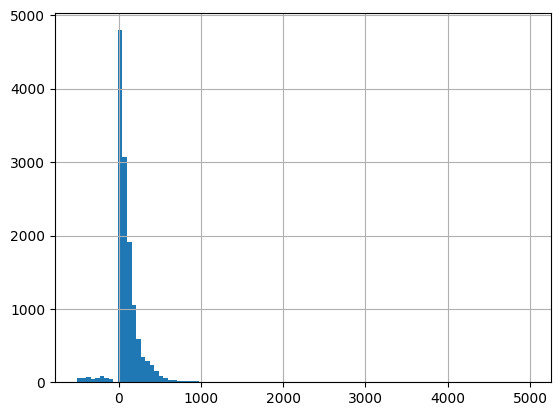

In [54]:
df[df.is_fraud == 1]['amount'].hist(bins=100)

## Question 2: Transaction type trend?

In [55]:
df.groupby(['use_chip', 'is_fraud']).size().unstack().fillna(0)

is_fraud,0,1
use_chip,,
Chip Transaction,3199600,3176
Online Transaction,1035196,8779
Swipe Transaction,4666835,1377


In [56]:
df.groupby('use_chip')['is_fraud'].value_counts(normalize=True).unstack()*100

is_fraud,0,1
use_chip,,
Chip Transaction,99.900836,0.099164
Online Transaction,99.159079,0.840921
Swipe Transaction,99.970503,0.029497


In [57]:
df.groupby('use_chip')['is_fraud'].mean().sort_values(ascending=False)*100

use_chip
Online Transaction    0.840921
Chip Transaction      0.099164
Swipe Transaction     0.029497
Name: is_fraud, dtype: float64

### INSIGHT -
Online transactions are most prone to fraud. They are ~8.5x more likely to be fraud than chip transactions.

In [58]:
df.groupby('merchant_city')['is_fraud'].value_counts(normalize=True).unstack()*100

is_fraud,0,1
merchant_city,,
Aaronsburg,100.0,NaN
Abbeville,100.0,NaN
Abbotsford,100.0,NaN
Abbott,100.0,NaN
Abbottstown,100.0,NaN
...,...,...
Zumbrota,100.0,NaN
Zuni,100.0,NaN
Zurich,100.0,NaN


In [59]:
df['abs_amount'] = df['amount'].abs()
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud,client_birth_year,client_birth_month,client_gender,client_latitude,client_longitude,card_brand,card_type,card_has_chip,card_acct_open_date,is_refund,txn_hour,txn_dayofweek,txn_month,client_age_at_txn,card_age_days,abs_amount
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors,0,1989,7,Female,46.80,-100.76,Mastercard,Debit (Prepaid),YES,2008-05-01,1,0,4,1,21,610,77.00
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors,0,1971,6,Male,40.80,-91.12,Mastercard,Credit,YES,2005-09-01,0,0,4,1,39,1583,14.57
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors,0,1970,4,Male,33.18,-117.29,Mastercard,Debit,YES,2006-01-01,0,0,4,1,40,1461,80.00
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No Errors,0,1968,5,Male,38.86,-76.60,Visa,Debit,YES,2009-07-01,0,0,4,1,42,184,46.41
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,No Errors,0,1972,12,Female,40.84,-73.87,Mastercard,Debit (Prepaid),YES,2008-01-01,0,0,4,1,38,731,4.81


In [60]:
df[df['is_refund']==0].groupby('is_fraud')['abs_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,8459342.0,50.430917,73.429294,0.0,11.030,31.84,66.2000,6613.44
1,12842.0,125.317457,201.641826,0.0,23.035,73.96,152.3975,4978.45


In [61]:
df[df['is_refund']==1].groupby('is_fraud')['abs_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,442289.0,102.172623,84.856036,0.01,64.00,79.0,93.00,500.0
1,490.0,285.057143,123.081718,56.00,185.25,279.5,388.75,500.0


## Question 3: Amount Distribution Trend?

<Axes: xlabel='abs_amount', ylabel='Count'>

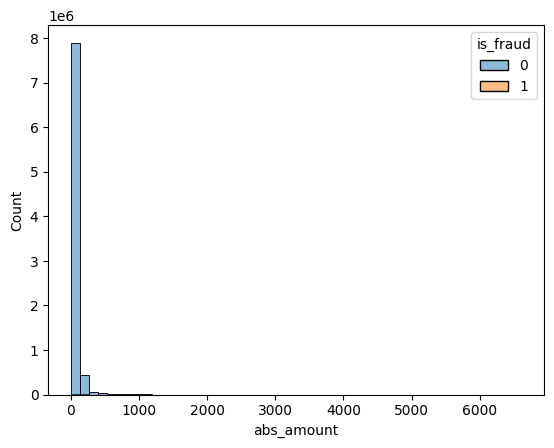

In [62]:
sns.histplot(
    data=df[df['is_refund']==0],
    x='abs_amount',
    hue='is_fraud',
    bins=50
)

Logarithms compress large values and spread small ones.

In [63]:
df['log_amount'] = np.log1p(df['abs_amount'])

<Axes: xlabel='log_amount', ylabel='Count'>

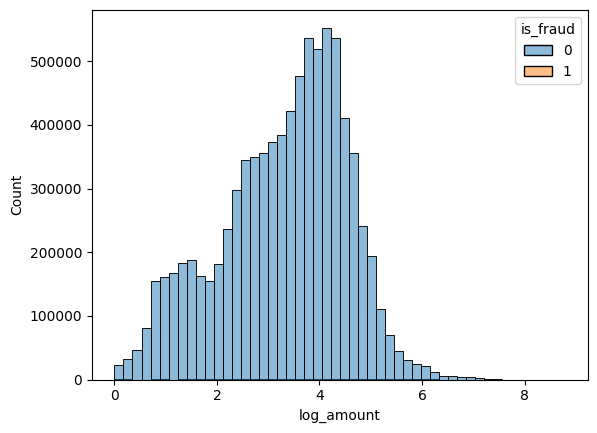

In [64]:
sns.histplot(
    data=df[df['is_refund']==0],
    x='log_amount',
    hue='is_fraud',
    bins=50
)

Still not visible, cause fraud rate is ~0.15%, so values are getting crushed. We'll use a KDE plot now.

<Axes: xlabel='log_amount', ylabel='Density'>

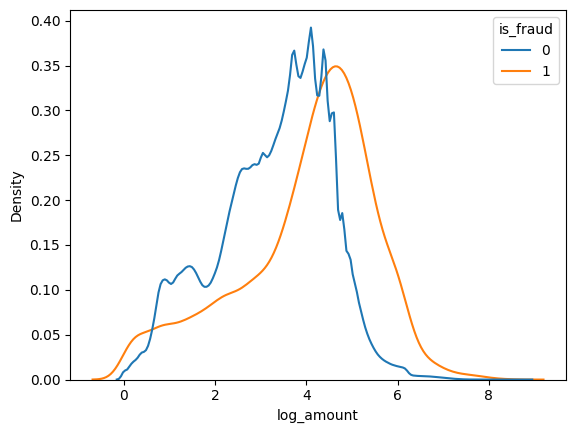

In [65]:
sns.kdeplot(
    data=df[df['is_refund'] == 0],
    x='log_amount',
    hue='is_fraud',
    common_norm=False
)

## Question 4: Time based fraud patterns

In [66]:
df = df.sort_values(['card_id', 'date'])
df.head(30)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud,client_birth_year,client_birth_month,client_gender,client_latitude,client_longitude,card_brand,card_type,card_has_chip,card_acct_open_date,is_refund,txn_hour,txn_dayofweek,txn_month,client_age_at_txn,card_age_days,abs_amount,log_amount
277,7475815,2010-01-01 07:07:00,1362,0,66.00,Swipe Transaction,59935,Bladensburg,MD,20710.0,5499,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,7,4,1,48,6940,66.00,4.204693
309,7475863,2010-01-01 07:17:00,1362,0,94.58,Swipe Transaction,59935,Bladensburg,MD,20710.0,5499,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,7,4,1,48,6940,94.58,4.559964
924,7476986,2010-01-01 11:35:00,1362,0,19.20,Swipe Transaction,94992,Bladensburg,MD,20710.0,5812,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,11,4,1,48,6940,19.20,3.005683
1821,7478589,2010-01-01 17:59:00,1362,0,49.64,Swipe Transaction,29214,Burke,VA,22015.0,5813,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,17,4,1,48,6940,49.64,3.924742
3073,7480810,2010-01-02 11:23:00,1362,0,16.20,Swipe Transaction,88646,Burke,VA,22015.0,5812,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,11,5,1,48,6941,16.20,2.844909
9701,7492666,2010-01-05 11:42:00,1362,0,15.15,Swipe Transaction,45926,Burke,VA,22015.0,5814,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,11,1,1,48,6944,15.15,2.781920
10898,7494776,2010-01-05 22:09:00,1362,0,15.56,Swipe Transaction,61195,Burke,VA,22015.0,5541,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,22,1,1,48,6944,15.56,2.806990
12318,7497251,2010-01-06 13:31:00,1362,0,72.33,Online Transaction,6063,ONLINE,ONLINE,0.0,4511,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,13,2,1,48,6945,72.33,4.294970
14229,7500564,2010-01-07 11:14:00,1362,0,14.56,Swipe Transaction,88646,Burke,VA,22015.0,5812,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,11,3,1,48,6946,14.56,2.744704
20636,7511873,2010-01-10 11:07:00,1362,0,16.51,Swipe Transaction,81185,Burke,VA,22015.0,5411,No Errors,0,1962,1,Male,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,11,6,1,48,6949,16.51,2.862772


In [67]:
df['delta_time_minutes'] = df.groupby('card_id')['date'].diff().dt.total_seconds() / 60
df

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud,client_birth_year,client_birth_month,...,client_latitude,client_longitude,card_brand,card_type,card_has_chip,card_acct_open_date,is_refund,txn_hour,txn_dayofweek,txn_month,client_age_at_txn,card_age_days,abs_amount,log_amount,delta_time_minutes
277,7475815,2010-01-01 07:07:00,1362,0,66.00,Swipe Transaction,59935,Bladensburg,MD,20710.0,5499,No Errors,0,1962,1,...,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,7,4,1,48,6940,66.00,4.204693,NaN
309,7475863,2010-01-01 07:17:00,1362,0,94.58,Swipe Transaction,59935,Bladensburg,MD,20710.0,5499,No Errors,0,1962,1,...,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,7,4,1,48,6940,94.58,4.559964,10.0
924,7476986,2010-01-01 11:35:00,1362,0,19.20,Swipe Transaction,94992,Bladensburg,MD,20710.0,5812,No Errors,0,1962,1,...,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,11,4,1,48,6940,19.20,3.005683,258.0
1821,7478589,2010-01-01 17:59:00,1362,0,49.64,Swipe Transaction,29214,Burke,VA,22015.0,5813,No Errors,0,1962,1,...,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,17,4,1,48,6940,49.64,3.924742,384.0
3073,7480810,2010-01-02 11:23:00,1362,0,16.20,Swipe Transaction,88646,Burke,VA,22015.0,5812,No Errors,0,1962,1,...,38.78,-77.27,Amex,Credit,YES,1991-01-01,0,11,5,1,48,6941,16.20,2.844909,1044.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888031,23711892,2019-10-21 09:14:00,1115,6138,34.28,Swipe Transaction,32175,Chandler,TX,75758.0,7538,No Errors,0,1966,9,...,32.32,-95.30,Visa,Debit,YES,2018-12-01,0,9,0,10,53,324,34.28,3.563316,49.0
8910182,23752972,2019-10-30 06:39:00,1115,6138,169.98,Online Transaction,56276,ONLINE,ONLINE,0.0,4899,No Errors,0,1966,9,...,32.32,-95.30,Visa,Debit,YES,2018-12-01,0,6,2,10,53,333,169.98,5.141547,12805.0
8910283,23753167,2019-10-30 07:23:00,1115,6138,64.49,Chip Transaction,81591,Tyler,TX,75706.0,5300,Technical Glitch,0,1966,9,...,32.32,-95.30,Visa,Debit,YES,2018-12-01,0,7,2,10,53,333,64.49,4.181897,44.0
8910437,23753430,2019-10-30 08:24:00,1115,6138,41.35,Chip Transaction,48919,Brownsboro,TX,75756.0,5311,No Errors,0,1966,9,...,32.32,-95.30,Visa,Debit,YES,2018-12-01,0,8,2,10,53,333,41.35,3.745968,61.0
